# Figuring out how to best translate DEG comparisons (backwards along the invading trophoblast trajectory) into MEFISTO factors

In [3]:
%matplotlib inline

import mofapy2 # needs 'pip install mofapy2'
import muon as mu # needs 'pip install muon'
import mudata as md
import os
import scanpy as sc
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata
import sklearn
from sklearn.linear_model import LogisticRegression
import pickle
from scipy.stats import norm


In [4]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [5]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_16122134

In [6]:
outdir = '/lustre/scratch117/cellgen/team292/aa22/with_Stijn/202111_snATAC-seq_data_MFI/multiome_ATAC_samples_analysis/trophoblast_only_analysis/downstream_analysis_custom_clust/out_MOFA_analysis/'


In [8]:
# read in from file to get factor weights
mdata = mu.read(outdir + 'adata_MEFISTO_with_VCT_20220210.h5mu')

In [9]:
# weights of MEFISTO factors from the model trained on 09.02.2022
mdata.obsm['X_mofa'] # from 1 to 10, factor 5 is ATAC-coverage driven

array([[-2.0562518 , -1.4895515 ,  0.55925083, ..., -0.13477103,
        -0.03984737, -0.05412919],
       [-1.4734516 ,  1.5175633 , -2.3260512 , ...,  1.4059056 ,
        -0.15271069,  0.07057329],
       [ 1.7865257 ,  0.12825087,  0.62174153, ..., -0.0363022 ,
        -0.83302337, -0.09488065],
       ...,
       [-1.8841873 , -1.9743074 , -1.0472622 , ...,  0.08861218,
         0.0958832 , -0.119697  ],
       [-1.3700093 ,  0.11284205,  0.9400662 , ...,  0.56025034,
        -0.09488616, -0.07153607],
       [-1.265812  , -1.626711  , -0.1312345 , ..., -0.00687388,
         0.05057646, -0.0682257 ]], dtype=float32)

In [10]:
mdata.obsm['X_mofa'].shape

(1605, 10)

In [11]:
mdata.obsm['X_mofa'][:,[0,1,2,3,5,6,7,8,9]]

array([[-2.0562518 , -1.4895515 ,  0.55925083, ..., -0.13477103,
        -0.03984737, -0.05412919],
       [-1.4734516 ,  1.5175633 , -2.3260512 , ...,  1.4059056 ,
        -0.15271069,  0.07057329],
       [ 1.7865257 ,  0.12825087,  0.62174153, ..., -0.0363022 ,
        -0.83302337, -0.09488065],
       ...,
       [-1.8841873 , -1.9743074 , -1.0472622 , ...,  0.08861218,
         0.0958832 , -0.119697  ],
       [-1.3700093 ,  0.11284205,  0.9400662 , ...,  0.56025034,
        -0.09488616, -0.07153607],
       [-1.265812  , -1.626711  , -0.1312345 , ..., -0.00687388,
         0.05057646, -0.0682257 ]], dtype=float32)

In [12]:
# without technical factor 5 (ATAC-coverage driven, non-smooth along pseudotime)
mdata.obsm['X_mofa_no_factor_5'] = mdata.obsm['X_mofa'][:,[0,1,2,3,5,6,7,8,9]]

In [13]:
# trying to plot factor weights for factors on top of this manifold..

# adding factor weights to the .obs of the object

for i in range(0,10):
    mdata.obs['X_mofa_Factor' + str(i+1)] = mdata.obsm['X_mofa'][:,i]

... storing 'ATAC_all:annotation' as categorical
... storing 'ATAC_all:gene_name' as categorical
... storing 'ATAC_all:gene_id' as categorical
... storing 'RNA:gene_ids-0' as categorical
... storing 'RNA:feature_types-0' as categorical
... storing 'RNA:genome-0' as categorical
... storing 'RNA:gene_ids-1' as categorical
... storing 'RNA:feature_types-1' as categorical
... storing 'RNA:genome-1' as categorical
... storing 'RNA:gene_ids-2' as categorical
... storing 'RNA:feature_types-2' as categorical
... storing 'RNA:genome-2' as categorical
... storing 'RNA:gene_ids-3' as categorical
... storing 'RNA:feature_types-3' as categorical
... storing 'RNA:genome-3' as categorical
... storing 'RNA:gene_ids-4' as categorical
... storing 'RNA:feature_types-4' as categorical
... storing 'RNA:genome-4' as categorical
... storing 'RNA:gene_ids-5' as categorical
... storing 'RNA:feature_types-5' as categorical
... storing 'RNA:genome-5' as categorical
... storing 'RNA:gene_ids-6' as categorical
...

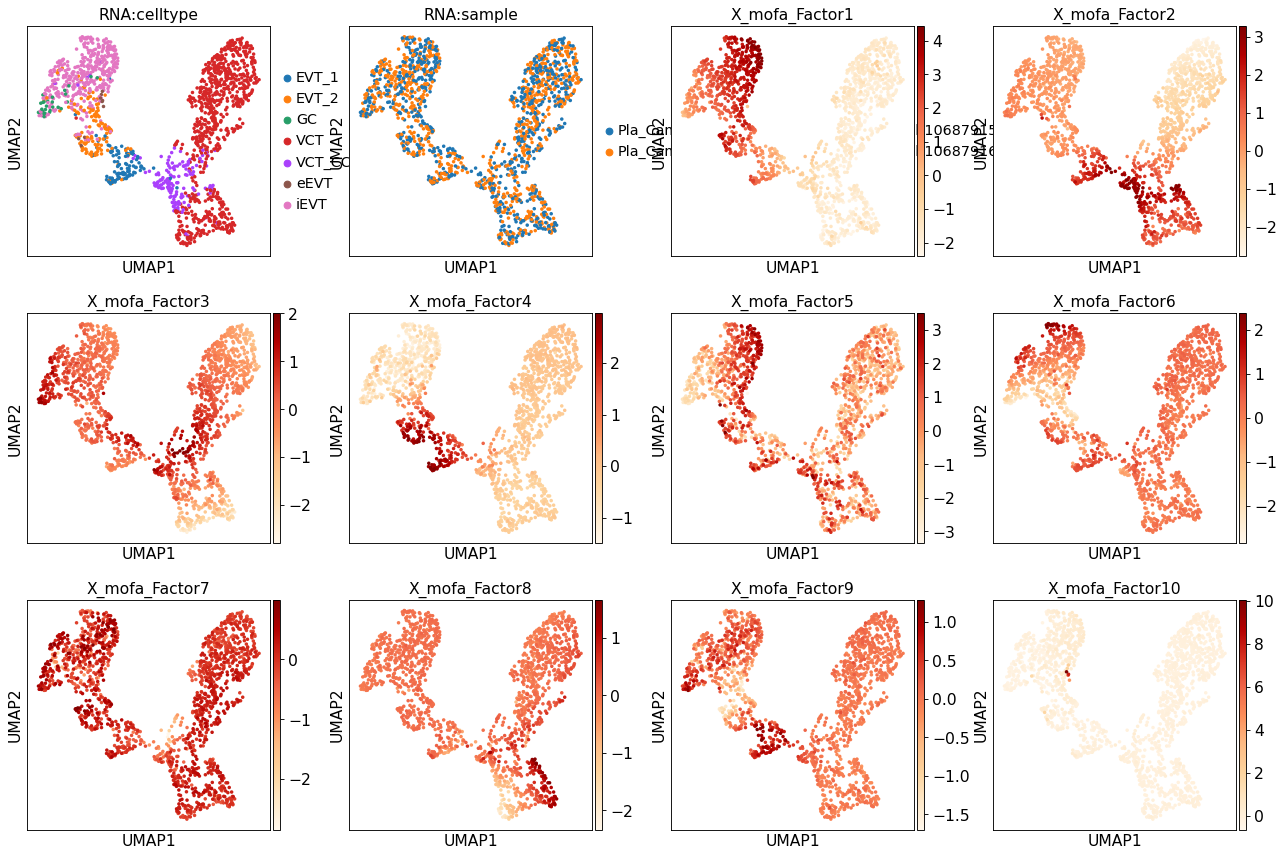

In [14]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)], #ncols=2, 
           size=40, cmap='OrRd'
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

In [12]:
# running logistic regression for every 2 cell types in a certain comparison

In [15]:
mdata.obs['RNA:celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: RNA:celltype, dtype: int64

In [16]:
# and likewise for all 6 comparisons used in DEG inference (backwards along the trajectory)
mdata_subsets = {}
celltypes_train = {}
train_mtx = {}

DE_comparisons = ['VCT_CCC_vs_VCT', 'EVT_1_vs_VCT_CCC', 'EVT_2_vs_EVT_1', 'eEVT_vs_EVT_2', 'iEVT_vs_EVT_2', 'GC_vs_iEVT']

for comparison in DE_comparisons:
    print(comparison)
    ct1 = comparison.split('_vs_')[0]
    ct2 = comparison.split('_vs_')[1]
    mdata_subsets[comparison] = mdata[mdata.obs['RNA:celltype'].isin([ct1,ct2])].copy()
    
    celltypes_train[comparison] = mdata_subsets[comparison].obs['RNA:celltype']
    
    train_mtx[comparison] = mdata_subsets[comparison].obsm['X_mofa_no_factor_5']
    print('shape of train_mtx here:', train_mtx[comparison].shape)

VCT_CCC_vs_VCT


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


shape of train_mtx here: (930, 9)
EVT_1_vs_VCT_CCC
shape of train_mtx here: (260, 9)
EVT_2_vs_EVT_1
shape of train_mtx here: (236, 9)
eEVT_vs_EVT_2
shape of train_mtx here: (139, 9)
iEVT_vs_EVT_2
shape of train_mtx here: (531, 9)
GC_vs_iEVT
shape of train_mtx here: (430, 9)


In [17]:
mdata.obs['RNA:celltype'].value_counts()

VCT        776
iEVT       401
VCT_CCC    154
EVT_2      130
EVT_1      106
GC          29
eEVT         9
Name: RNA:celltype, dtype: int64

Using all 10 factors (may consider exculding technical factor 5 later?)

In [18]:
# Load models from saved files

logisticRegr = {}

for comparison in DE_comparisons:
    print(comparison)
    pkl_filename = './logreg_models/logreg_MEFISTO_model_comparison_' + comparison + '_20220211.pkl'
    
    with open(pkl_filename, 'rb') as file:  
        logisticRegr[comparison] =  pickle.load(file)
    
    



VCT_CCC_vs_VCT
EVT_1_vs_VCT_CCC
EVT_2_vs_EVT_1
eEVT_vs_EVT_2
iEVT_vs_EVT_2
GC_vs_iEVT


In [19]:
coef_df = pd.DataFrame(index = ['X_mofa_Factor' + str(i+1) for i in [0,1,2,3,5,6,7,8,9]],
                       columns = DE_comparisons,)

for comparison in DE_comparisons:
    print(comparison)
    coef_df[comparison] = list(logisticRegr[comparison].coef_)[0]

VCT_CCC_vs_VCT
EVT_1_vs_VCT_CCC
EVT_2_vs_EVT_1
eEVT_vs_EVT_2
iEVT_vs_EVT_2
GC_vs_iEVT


In [20]:
coef_df

VCT_CCC_vs_VCT  EVT_1_vs_VCT_CCC  EVT_2_vs_EVT_1  \
X_mofa_Factor1         1.362897         -1.010847        0.543542   
X_mofa_Factor2         1.576147         -0.174173       -1.417647   
X_mofa_Factor3         1.506838         -0.007015        0.035531   
X_mofa_Factor4         0.763690         -1.792258       -0.491769   
X_mofa_Factor6         0.210710         -0.053273       -0.043131   
X_mofa_Factor7        -0.865653         -0.554437        0.152823   
X_mofa_Factor8        -0.411605          0.202259        0.058136   
X_mofa_Factor9         0.268838         -0.599209       -1.221138   
X_mofa_Factor10       -0.088446          0.207209       -0.351394   

                 eEVT_vs_EVT_2  iEVT_vs_EVT_2  GC_vs_iEVT  
X_mofa_Factor1        0.262577      -0.213234    0.609525  
X_mofa_Factor2       -0.073845      -0.304036   -0.061665  
X_mofa_Factor3        0.057484      -0.277484   -0.438798  
X_mofa_Factor4       -0.035714      -1.608722    0.833886  
X_mofa_Factor6        0.183507       0.438625    0.766341  
X_mofa_Factor7        0.378336       0.491014   -0.587297  
X_mofa_Factor8        0.037936      -0.276521    0.011805  
X_mofa_Factor9        0.017285       0.724455   -1.132417  
X_mofa_Factor10       1.210770       0.483628    0.042544

<AxesSubplot:>

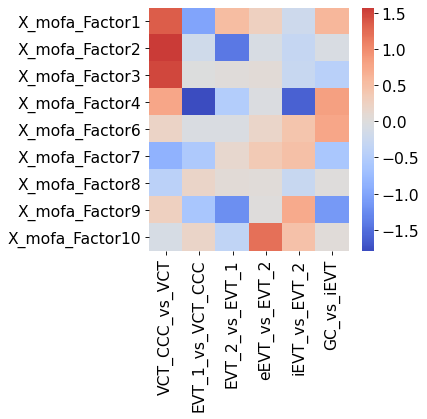

In [21]:
sns.heatmap(coef_df, center = 0, cmap='coolwarm')

In [22]:
coef_df.index[np.argmax(coef_df['VCT_CCC_vs_VCT'])]

'X_mofa_Factor2'

In [23]:
for comparison in DE_comparisons:
    print(comparison)
    print('top factor to explain comparison', comparison, 'is', coef_df.index[np.argmax(coef_df[comparison])])

VCT_CCC_vs_VCT
top factor to explain comparison VCT_CCC_vs_VCT is X_mofa_Factor2
EVT_1_vs_VCT_CCC
top factor to explain comparison EVT_1_vs_VCT_CCC is X_mofa_Factor10
EVT_2_vs_EVT_1
top factor to explain comparison EVT_2_vs_EVT_1 is X_mofa_Factor1
eEVT_vs_EVT_2
top factor to explain comparison eEVT_vs_EVT_2 is X_mofa_Factor10
iEVT_vs_EVT_2
top factor to explain comparison iEVT_vs_EVT_2 is X_mofa_Factor9
GC_vs_iEVT
top factor to explain comparison GC_vs_iEVT is X_mofa_Factor4


Scikit-learn deliberately does not support statistical inference. If you want out-of-the-box coefficients significance tests (and much more), you can use Logit estimator from Statsmodels. This package mimics interface glm models in R, so you could find it familiar.

If you still want to stick to scikit-learn LogisticRegression, you can use asymtotic approximation to distribution of maximum likelihiood estimates. Precisely, for a vector of maximum likelihood estimates theta, its variance-covariance matrix can be estimated as inverse(H), where H is the Hessian matrix of log-likelihood at theta. This is exactly what the function below does:

In [24]:
# solution from here: https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
x = np.arange(10)[:, np.newaxis]
y = np.array([0,0,0,1,0,0,1,1,1,1])
model = LogisticRegression(C=1e30).fit(x, y)
print(logit_pvalue(model, x))


[0.11413069 0.08780009]


In [25]:
# compare with statsmodels
import statsmodels.api as sm
sm_model = sm.Logit(y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()


[0.11413093 0.08779979]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                          Logit   Df Residuals:                        8
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Feb 2022   Pseudo R-squ.:                  0.4856
Time:                        11:59:37   Log-Likelihood:                -3.5656
converged:                       True   LL-Null:                       -6.9315
Covariance Type:            nonrobust   LLR p-value:                  0.009472
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9587      2.506     -1.580      0.114      -8.870       0.952
x1             0.8797      0.515      1.707      0.088      -0.130       1.890
==============================================================================
"""

In [26]:
# the first value here is the p-value for constant in log regression, whereas the following 9 values are p-values for predictors (factors in our case)
logit_pvalue(model=logisticRegr['VCT_CCC_vs_VCT'], x=train_mtx['VCT_CCC_vs_VCT'])


array([2.05438079e-01, 1.23886683e-06, 0.00000000e+00, 3.55893093e-12,
       4.35163061e-01, 7.83700099e-01, 8.33074498e-02, 5.90350635e-02,
       8.25602410e-01, 9.58384601e-01])

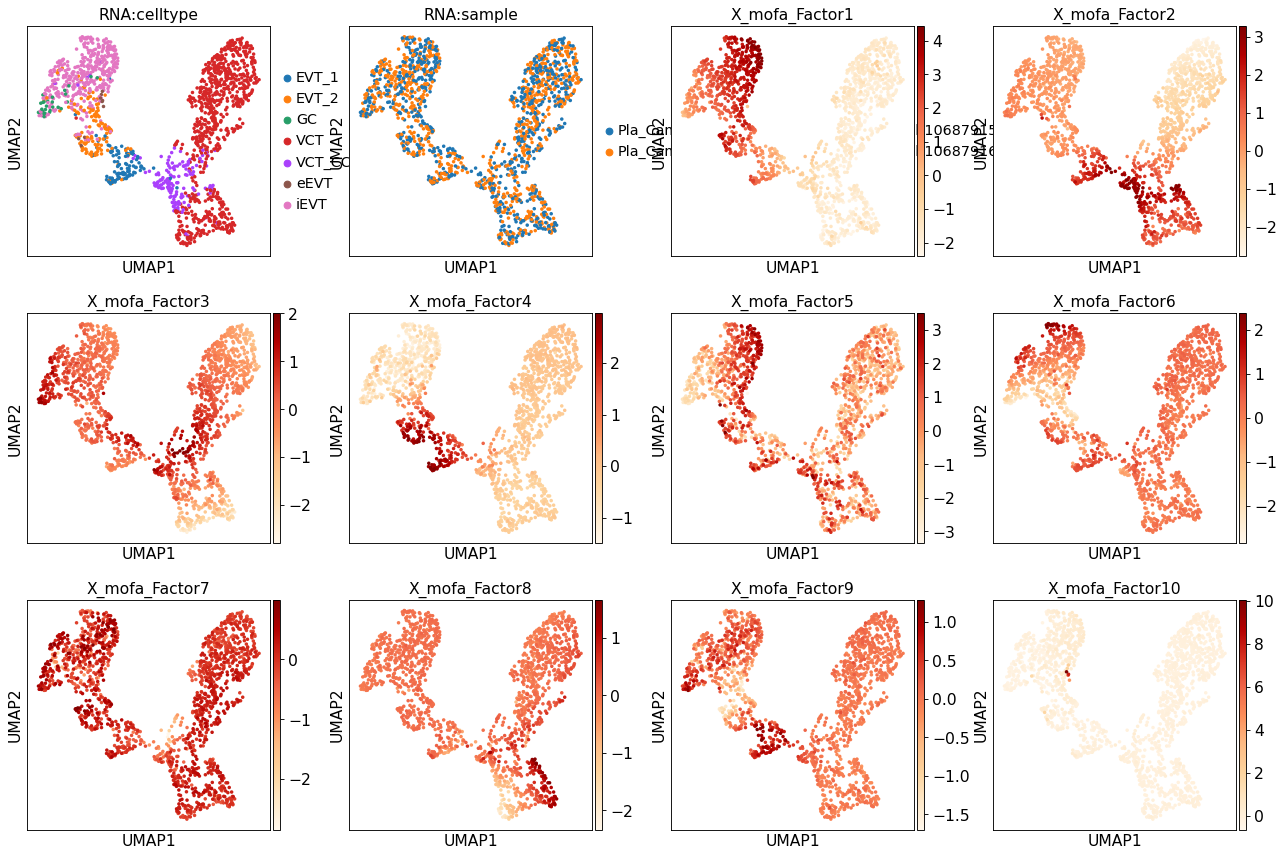

In [83]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)], #ncols=2, 
           size=40, cmap='OrRd'
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

In [89]:
# the sign of factor weight/feature contribution to each classifier depends on the order of classes within each model so let's check this here & remember

logreg_direction_sign = {}

for comparison in DE_comparisons:
    print(comparison)
    
    DE_comp_cell_types = comparison.split('_vs_')
    
    print('order of cell types in comparison', DE_comp_cell_types)
    
    # in logistic regrssion, factors contirbute to classes[1] vs classes[0] comparison
    logreg_direction = [logisticRegr[comparison].classes_[1], logisticRegr[comparison].classes_[0]]
    
    print('direction of classification here', logreg_direction)
    
    if DE_comp_cell_types != logreg_direction:
        print("in this case there is a mismatch due to alphabetical sorting of class names, so let's remember to flip signs of coefficients later")
        logreg_direction_sign[comparison] = -1
    else:
        logreg_direction_sign[comparison] = 1
    
    #print(logisticRegr[comparison].coef_)
    print('\n')
    
    

VCT_CCC_vs_VCT
order of cell types in comparison ['VCT_CCC', 'VCT']
direction of classification here ['VCT_CCC', 'VCT']


EVT_1_vs_VCT_CCC
order of cell types in comparison ['EVT_1', 'VCT_CCC']
direction of classification here ['VCT_CCC', 'EVT_1']
in this case there is a mismatch due to alphabetical sorting of class names, so let's remember to flip signs of coefficients later


EVT_2_vs_EVT_1
order of cell types in comparison ['EVT_2', 'EVT_1']
direction of classification here ['EVT_2', 'EVT_1']


eEVT_vs_EVT_2
order of cell types in comparison ['eEVT', 'EVT_2']
direction of classification here ['eEVT', 'EVT_2']


iEVT_vs_EVT_2
order of cell types in comparison ['iEVT', 'EVT_2']
direction of classification here ['iEVT', 'EVT_2']


GC_vs_iEVT
order of cell types in comparison ['GC', 'iEVT']
direction of classification here ['iEVT', 'GC']
in this case there is a mismatch due to alphabetical sorting of class names, so let's remember to flip signs of coefficients later




In [90]:
logreg_direction_sign

{'VCT_CCC_vs_VCT': 1,
 'EVT_1_vs_VCT_CCC': -1,
 'EVT_2_vs_EVT_1': 1,
 'eEVT_vs_EVT_2': 1,
 'iEVT_vs_EVT_2': 1,
 'GC_vs_iEVT': -1}

In [91]:
pvals_df = pd.DataFrame(index = ['X_mofa_Factor' + str(i+1) for i in [0,1,2,3,5,6,7,8,9]],
                       columns = DE_comparisons,)

for comparison in DE_comparisons:
    print(comparison)
    pvals_df[comparison] = logit_pvalue(model=logisticRegr[comparison], x=train_mtx[comparison])[1:]


VCT_CCC_vs_VCT
EVT_1_vs_VCT_CCC
EVT_2_vs_EVT_1
eEVT_vs_EVT_2
iEVT_vs_EVT_2
GC_vs_iEVT


In [93]:
# getting to -log10(pval)
pvals_df_neglog = -np.log10(pvals_df)

In [94]:
neglog_cutoff = 1 # so cutting off all FDRs > 0.1
neglog_cutoff

1

In [95]:
pvals_df_neglog[pvals_df_neglog > neglog_cutoff]

VCT_CCC_vs_VCT  EVT_1_vs_VCT_CCC  EVT_2_vs_EVT_1  \
X_mofa_Factor1         5.906975          1.402701             NaN   
X_mofa_Factor2              inf               NaN        1.207928   
X_mofa_Factor3        11.448680               NaN             NaN   
X_mofa_Factor4              NaN          3.030214             NaN   
X_mofa_Factor6              NaN               NaN             NaN   
X_mofa_Factor7         1.079316               NaN             NaN   
X_mofa_Factor8         1.228890               NaN             NaN   
X_mofa_Factor9              NaN               NaN        1.268706   
X_mofa_Factor10             NaN               NaN             NaN   

                 eEVT_vs_EVT_2  iEVT_vs_EVT_2  GC_vs_iEVT  
X_mofa_Factor1             NaN            NaN         NaN  
X_mofa_Factor2             NaN            NaN         NaN  
X_mofa_Factor3             NaN            NaN         NaN  
X_mofa_Factor4             NaN            inf         NaN  
X_mofa_Factor6             NaN       2.044408    1.575825  
X_mofa_Factor7             NaN            NaN         NaN  
X_mofa_Factor8             NaN            NaN         NaN  
X_mofa_Factor9             NaN       1.582831         NaN  
X_mofa_Factor10       1.373903            NaN         NaN

In [96]:
coef_df

VCT_CCC_vs_VCT  EVT_1_vs_VCT_CCC  EVT_2_vs_EVT_1  \
X_mofa_Factor1         1.362897         -1.010847        0.543542   
X_mofa_Factor2         1.576147         -0.174173       -1.417647   
X_mofa_Factor3         1.506838         -0.007015        0.035531   
X_mofa_Factor4         0.763690         -1.792258       -0.491769   
X_mofa_Factor6         0.210710         -0.053273       -0.043131   
X_mofa_Factor7        -0.865653         -0.554437        0.152823   
X_mofa_Factor8        -0.411605          0.202259        0.058136   
X_mofa_Factor9         0.268838         -0.599209       -1.221138   
X_mofa_Factor10       -0.088446          0.207209       -0.351394   

                 eEVT_vs_EVT_2  iEVT_vs_EVT_2  GC_vs_iEVT  
X_mofa_Factor1        0.262577      -0.213234    0.609525  
X_mofa_Factor2       -0.073845      -0.304036   -0.061665  
X_mofa_Factor3        0.057484      -0.277484   -0.438798  
X_mofa_Factor4       -0.035714      -1.608722    0.833886  
X_mofa_Factor6        0.183507       0.438625    0.766341  
X_mofa_Factor7        0.378336       0.491014   -0.587297  
X_mofa_Factor8        0.037936      -0.276521    0.011805  
X_mofa_Factor9        0.017285       0.724455   -1.132417  
X_mofa_Factor10       1.210770       0.483628    0.042544

In [102]:
# so let's not consider non-significant cells in this table when looking at coef_df

translation_df_comparison2factor = pd.DataFrame(index=DE_comparisons,
                                               columns = ['MEFISTO_factor','contribution'])

for comparison in DE_comparisons:
    print(comparison)
    
    curr_coefs_significant_abs = abs(coef_df.loc[-np.isnan(pvals_df_neglog[pvals_df_neglog > neglog_cutoff].loc[:,comparison]), comparison])
    curr_coefs_significant = coef_df.loc[-np.isnan(pvals_df_neglog[pvals_df_neglog > neglog_cutoff].loc[:,comparison]), comparison]

    curr_top_factor = curr_coefs_significant_abs.index[np.argmax(curr_coefs_significant_abs)]
    
    curr_top_factor_coef = curr_coefs_significant.loc[curr_top_factor]
    
    print('top significant factor to explain comparison', comparison, 'is', curr_top_factor, 'with coef:', curr_top_factor_coef)
    print('direction of comparison here:', logreg_direction_sign[comparison])
    
    translation_df_comparison2factor.loc[comparison, 'MEFISTO_factor'] = curr_top_factor
    
    # direction of contribution of top factor to a particular comparison
    final_effect_direction = curr_top_factor_coef * logreg_direction_sign[comparison]
    
    if final_effect_direction > 0:
        print('in this case top factor', curr_top_factor, 'is contributing (+) weight to the model, so upreg MEFISTO results should be considered')
        translation_df_comparison2factor.loc[comparison, 'contribution'] = '+'
    elif final_effect_direction < 0:
        print('in this case top factor', curr_top_factor, 'is contributing (-) weight to the model, so downreg MEFISTO results should be considered')
        translation_df_comparison2factor.loc[comparison, 'contribution'] = '-'
    else:
        print('direction of final effect is 0')
    
    print('\n')

VCT_CCC_vs_VCT
top significant factor to explain comparison VCT_CCC_vs_VCT is X_mofa_Factor2 with coef: 1.576146649880339
direction of comparison here: 1
in this case top factor X_mofa_Factor2 is contributing (+) weight to the model, so upreg MEFISTO results should be considered


EVT_1_vs_VCT_CCC
top significant factor to explain comparison EVT_1_vs_VCT_CCC is X_mofa_Factor4 with coef: -1.792258082206187
direction of comparison here: -1
in this case top factor X_mofa_Factor4 is contributing (+) weight to the model, so upreg MEFISTO results should be considered


EVT_2_vs_EVT_1
top significant factor to explain comparison EVT_2_vs_EVT_1 is X_mofa_Factor2 with coef: -1.417646792720677
direction of comparison here: 1
in this case top factor X_mofa_Factor2 is contributing (-) weight to the model, so downreg MEFISTO results should be considered


eEVT_vs_EVT_2
top significant factor to explain comparison eEVT_vs_EVT_2 is X_mofa_Factor10 with coef: 1.210770049776716
direction of comparison 

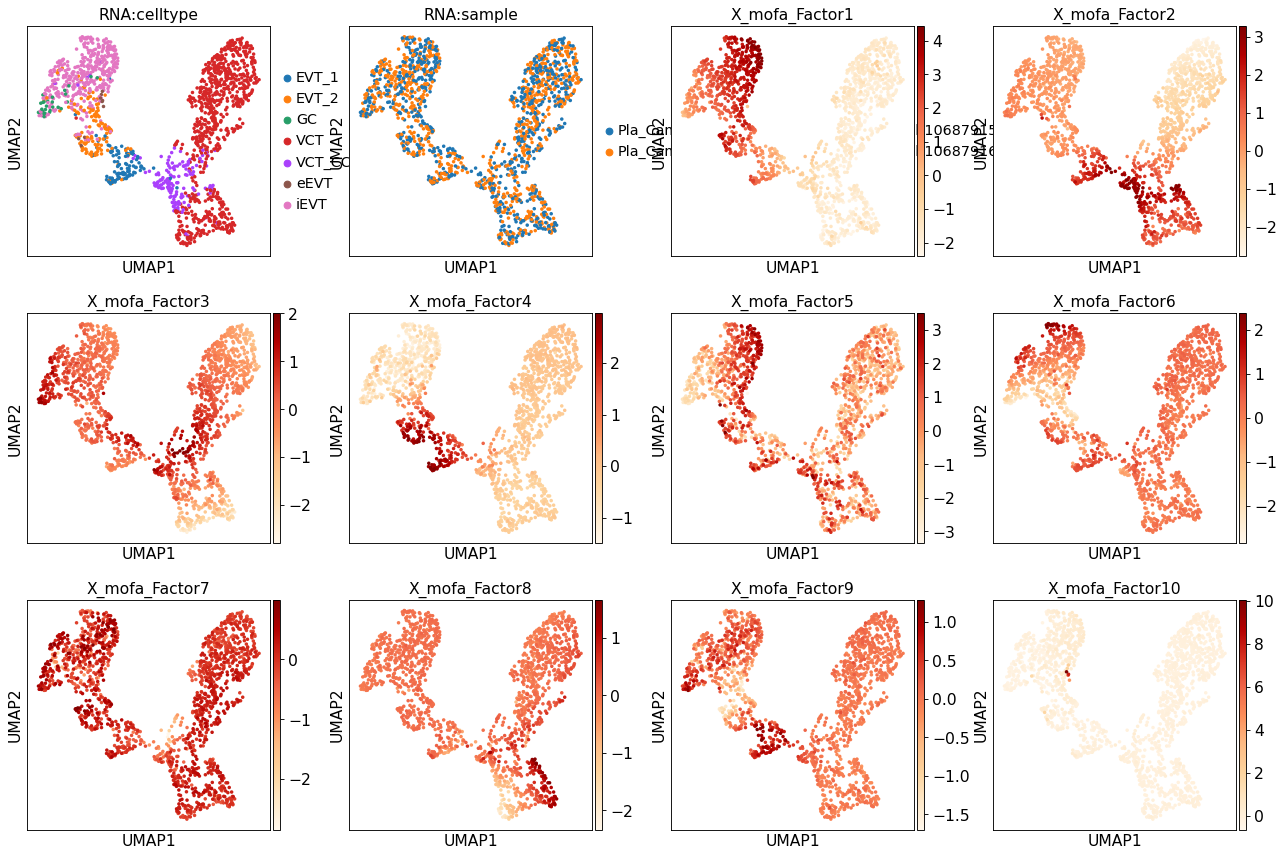

In [62]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)], #ncols=2, 
           size=40, cmap='OrRd'
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

In [103]:
translation_df_comparison2factor

MEFISTO_factor contribution
VCT_CCC_vs_VCT     X_mofa_Factor2            +
EVT_1_vs_VCT_CCC   X_mofa_Factor4            +
EVT_2_vs_EVT_1     X_mofa_Factor2            -
eEVT_vs_EVT_2     X_mofa_Factor10            +
iEVT_vs_EVT_2      X_mofa_Factor4            -
GC_vs_iEVT         X_mofa_Factor6            -

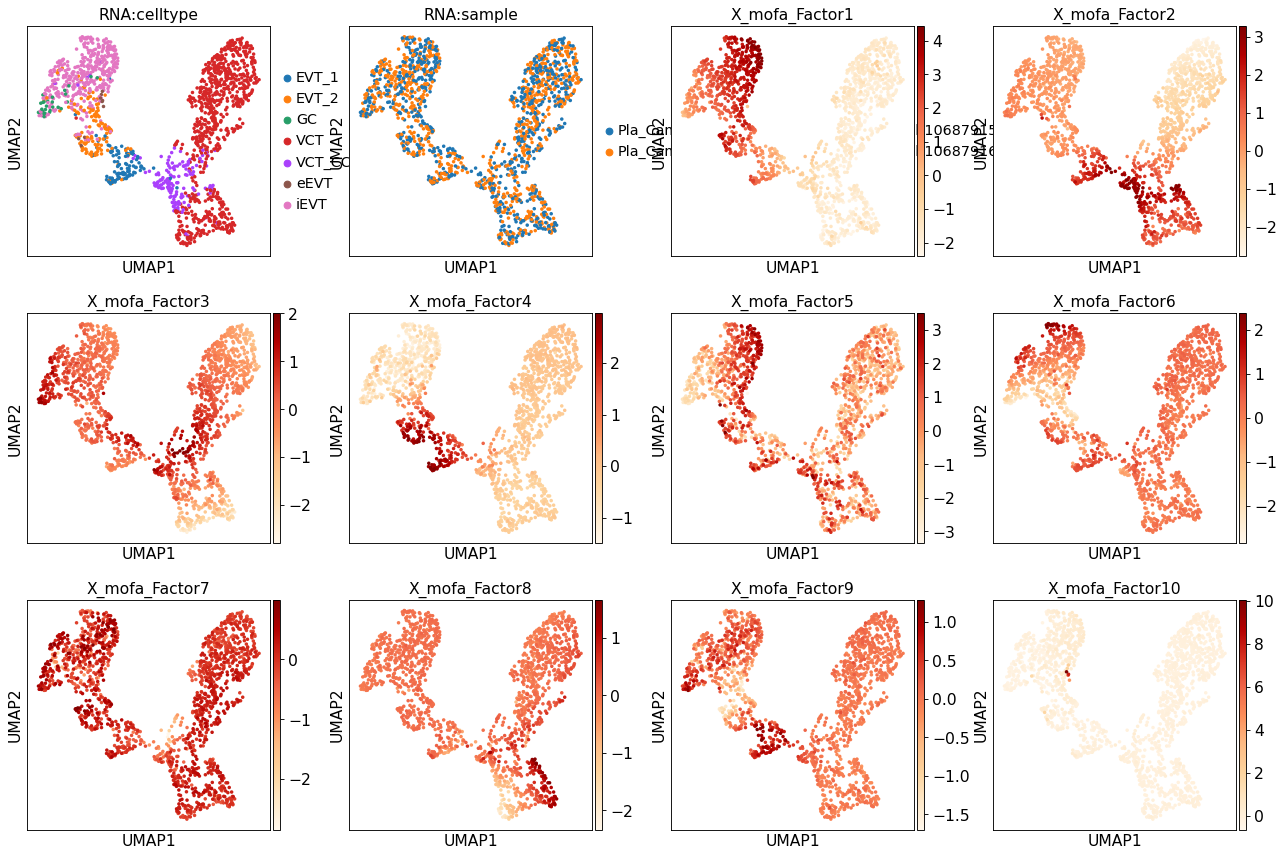

In [83]:
sc.pl.umap(mdata, color=["RNA:celltype", "RNA:sample"] + ['X_mofa_Factor' + str(i+1) for i in range(0,10)], #ncols=2, 
           size=40, cmap='OrRd'
           #save='_MOFA_based_UMAP_celltype_sample.pdf'
          )

# This is the translation of DEG comparisons --> MEFISTO factors to be used in TF prioritisation in notebook M9

In [104]:
# saving this as a dataframe for further use
translation_df_comparison2factor.to_csv('./tables/20220213_translation_df_comparison2factor.csv')